YOLOv8-like Model -> Test Loss: 0.2417 | Test Accuracy: 0.9165
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step


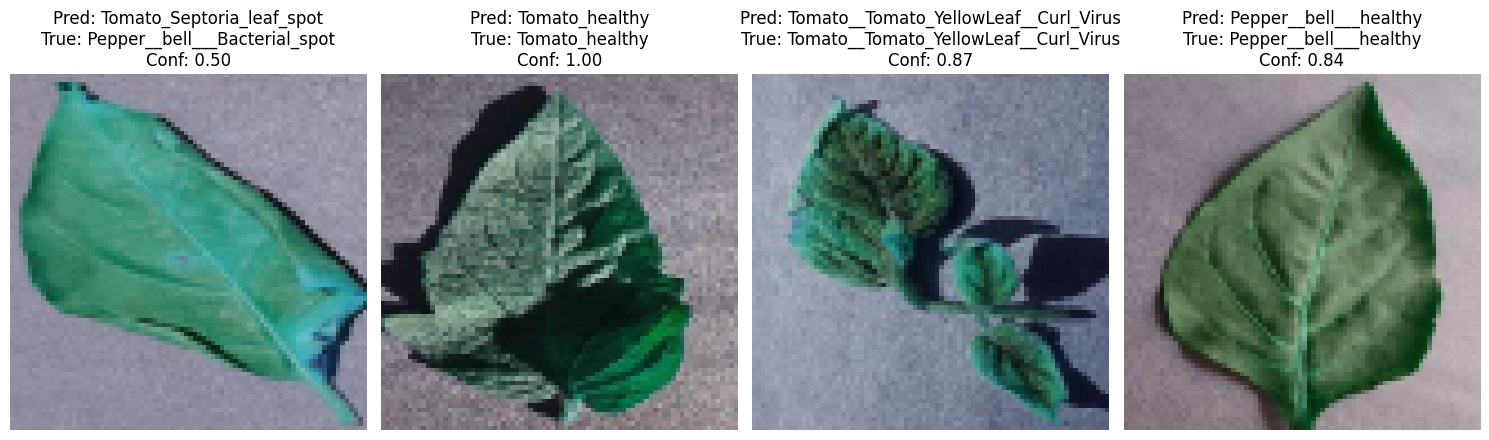

In [4]:
import os
import numpy as np
import cv2
from keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

# ==============
# 1. LOAD MODEL
# ==============
yolo_model = tf.keras.models.load_model("./yolo_v8_classification_model.keras")

# ============================
# 2. CLASSIFICATION TYPE LIST
# ============================
classification_types = [
    'Pepper__bell___Bacterial_spot','Pepper__bell___healthy',
    'Potato___Early_blight','Potato___Late_blight','Potato___healthy',
    'Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight',
    'Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

# ================
# 3. DEFINE PARAMS
# ================
IMAGE_SIZE = 80
COLORS = 3
NUM_CLASSES = len(classification_types)

# =================
# 4. LOAD TEST DATA
# =================
test_dir = "../PlantVillageTest"

test_files = []
for disease_id, disease_name in enumerate(classification_types):
    disease_folder = os.path.join(test_dir, disease_name)
    for file_name in os.listdir(disease_folder):
        full_path = os.path.join(disease_folder, file_name)
        test_files.append([full_path, disease_id])

X_test = np.zeros((len(test_files), IMAGE_SIZE, IMAGE_SIZE, COLORS), dtype=np.float32)
test_labels = []

for i, (path, disease_id) in enumerate(test_files):
    img = cv2.imread(path)
    if img is not None:
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
        img_resized = img_resized / 255.0
        X_test[i] = img_resized
    test_labels.append(disease_id)

y_test = to_categorical(test_labels, num_classes=NUM_CLASSES)

# ======================
# 5. EVALUATE ON TEST SET
# ======================
test_loss, test_acc = yolo_model.evaluate(X_test, y_test, verbose=0)
print(f"YOLOv8-like Model -> Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# =================================================
# 6. PREDICT AND DISPLAY SAMPLE IMAGES + ACCURACIES
# =================================================
predictions = yolo_model.predict(X_test)  # shape: (num_test_images, NUM_CLASSES)
predicted_class_ids = np.argmax(predictions, axis=1)
true_class_ids = np.argmax(y_test, axis=1)

# Let's show a few random images from the test set
num_to_show = 4
random_indices = np.random.choice(len(X_test), num_to_show, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(1, num_to_show, i + 1)
    # X_test is already normalized [0, 1], so we can display it directly
    plt.imshow(X_test[idx])
    
    pred_id = predicted_class_ids[idx]
    conf = predictions[idx][pred_id]  # confidence = probability of predicted class
    pred_label = classification_types[pred_id]
    true_label = classification_types[true_class_ids[idx]]
    
    # Title showing predicted label, ground truth, and confidence
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}\nConf: {conf:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()
